In [115]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [2]:
call = pd.read_csv('train.csv')
data = pd.DataFrame(call)

In [3]:
data = data.dropna(axis = 0, how = 'any')

In [4]:
data.isnull().sum()

id                 0
departure city     0
discount           0
price              0
no of items        0
location           0
class              0
segment            0
sub-class          0
delivery type      0
RID                0
profit             0
delivery date      0
address code       0
departure state    0
placement date     0
dtype: int64

In [5]:
data.head(2)

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date
0,1,Houston,0.2,16.448,2,Central,kariox,Consumer,phone,Standard Class,7981,5.5512,01-01-2018,77095,Texas,01-01-2018
1,2,Westland,0.0,29.700,5,Central,kariox,Consumer,headset,Standard Class,6334,13.3650,01-01-2018,48185,Michigan,01-01-2018


In [6]:
data['delivery date'] = pd.to_datetime(data['delivery date'])
data['placement date'] = pd.to_datetime(data['placement date'])
data['duration'] = (data['delivery date'] - data['placement date']).dt.days

In [7]:
bins = [-0.5, 0, 0.3, 0.6, 0.9]
labels = [0,1,2,3]
data['discount_binned'] = pd.cut(data['discount'], bins=bins, labels=labels)

In [8]:
data.isnull().sum()

id                 0
departure city     0
discount           0
price              0
no of items        0
location           0
class              0
segment            0
sub-class          0
delivery type      0
RID                0
profit             0
delivery date      0
address code       0
departure state    0
placement date     0
duration           0
discount_binned    0
dtype: int64

In [43]:
bin = [0, 1.55, 3.5, 5.5, 11, 20]
label = [0,1,2,3, 4]
data['no of items_binned'] = pd.cut(data['no of items'], bins=bin, labels=label)

In [44]:
data['no of items_binned'].isnull().sum()

0

In [45]:
data.describe()

,id,discount,price,no of items,RID,profit,address code,duration
count,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000
mean,3350.992088,0.155899,4.121871,3.798627,4954.326019,29.124000,54713.799373,6.241976
std,1933.992657,0.205929,1.652408,2.225472,2921.519449,230.730047,32091.912840,46.212168
min,1.000000,0.000000,-0.179127,1.000000,1.000000,-6599.978000,1040.000000,0.000000
25%,1676.500000,0.000000,2.853016,2.000000,2389.500000,1.713700,22204.000000,0.000000
50%,3351.000000,0.200000,4.006606,3.000000,4941.000000,8.802000,55113.000000,0.000000
75%,5025.500000,0.200000,5.361010,5.000000,7507.500000,30.023400,90004.000000,0.000000
max,6700.000000,0.800000,10.027406,14.000000,9990.000000,8399.976000,99301.000000,355.000000


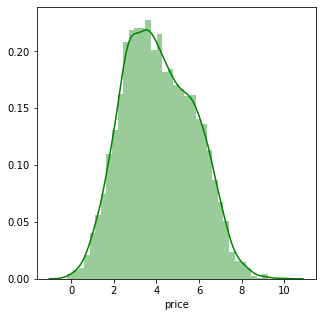

In [46]:
plt.figure(figsize=(5,5))
plt.figure(1)
sns.distplot(data['price'],color='green')

In [47]:
segment = pd.get_dummies(data['segment'])
classes = pd.get_dummies(data['class'])
location = pd.get_dummies(data['location'])
# Above in the business_code column we can see they are categorical ones, so we make new feature
# out of them 
data1 = pd.concat([data, segment, classes, location], axis = 1)

In [48]:
delivery_type = pd.get_dummies(data['delivery type'])
# Above in the business_code column we can see they are categorical ones, so we make new feature
# out of them 
data1 = pd.concat([data1, delivery_type], axis = 1)

In [49]:
ref = dict(data1['address code'].value_counts())

data1['address code_new'] = data1['address code'].map(ref)

In [50]:
data1.head(2)

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,...,qexty,Central,East,South,West,First Class,Same Day,Second Class,Standard Class,address code_new
0,1,Houston,0.2,2.800204,2,Central,kariox,Consumer,phone,Standard Class,...,0,1,0,0,0,0,0,0,1,67
1,2,Westland,0.0,3.391147,5,Central,kariox,Consumer,headset,Standard Class,...,0,1,0,0,0,0,0,0,1,13


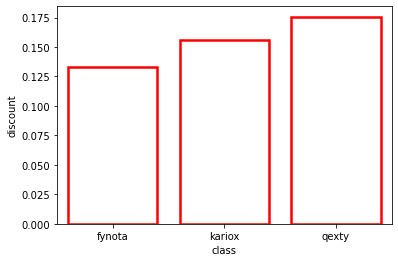

In [51]:
temp = pd.DataFrame(data1.groupby(['class'], axis=0, as_index=False)['discount'].mean())
plt.figure(figsize=(6,4))
graph = sns.barplot(x="class", y="discount",data=temp,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".4", edgecolor="red")

In [52]:
def Mapper(num):
    t = 0
    if num > 0.5:
        return t
    else:
        t = 1
        return t
    
data1['Mapped_discount'] = data1['discount'].apply(Mapper)
data1.head(2)

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,...,Central,East,South,West,First Class,Same Day,Second Class,Standard Class,address code_new,Mapped_discount
0,1,Houston,0.2,2.800204,2,Central,kariox,Consumer,phone,Standard Class,...,1,0,0,0,0,0,0,1,67,1
1,2,Westland,0.0,3.391147,5,Central,kariox,Consumer,headset,Standard Class,...,1,0,0,0,0,0,0,1,13,1


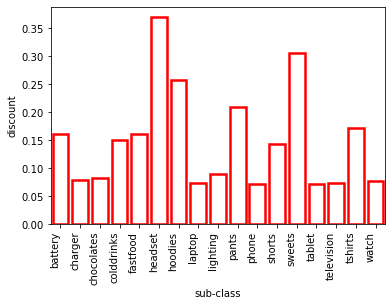

In [54]:
# can make a column out of this.
temp = pd.DataFrame(data1.groupby(['sub-class'], axis=0, as_index=False)['discount'].mean())
plt.figure(figsize=(6,4))
graph = sns.barplot(x="sub-class", y="discount",data=temp,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".4", edgecolor="red")

graph = graph.set_xticklabels(graph.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')

In [55]:
temp_dict1 = dict(temp.values)

data1['subclass_discount_mapped'] = data1['sub-class'].map(temp_dict1)
data1.head(2)

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,...,East,South,West,First Class,Same Day,Second Class,Standard Class,address code_new,Mapped_discount,subclass_discount_mapped
0,1,Houston,0.2,2.800204,2,Central,kariox,Consumer,phone,Standard Class,...,0,0,0,0,0,0,1,67,1,0.072368
1,2,Westland,0.0,3.391147,5,Central,kariox,Consumer,headset,Standard Class,...,0,0,0,0,0,0,1,13,1,0.369561


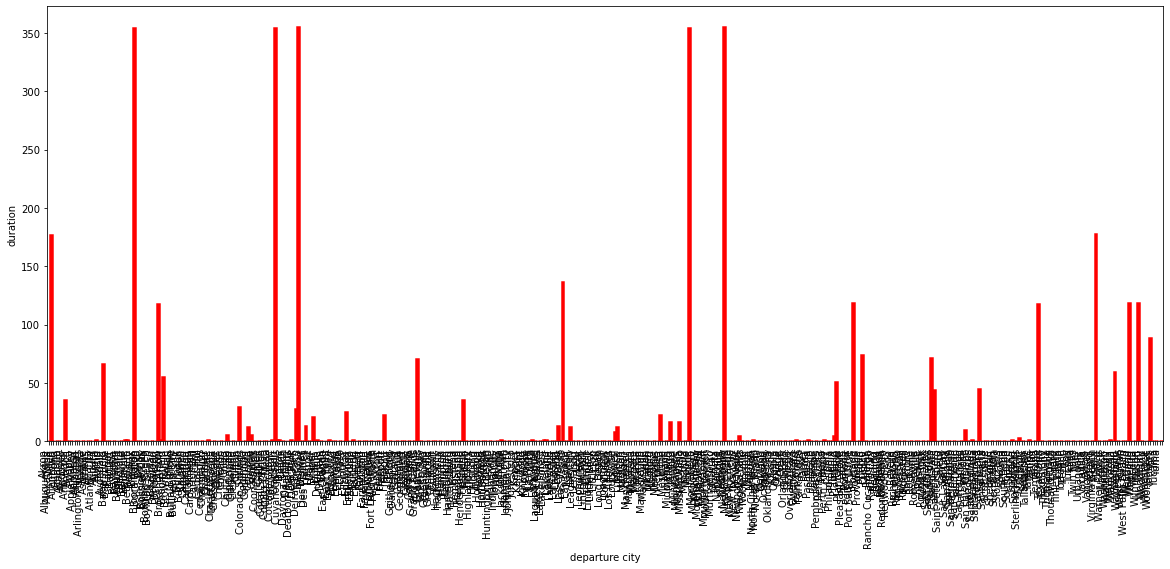

In [65]:
# can make a column out of this.
temp = pd.DataFrame(data1.groupby(['departure city'], axis=0, as_index=False)['duration'].mean())
plt.figure(figsize=(20,8))
graph = sns.barplot(x="departure city", y="duration",data=temp,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".4", edgecolor="red")

graph = graph.set_xticklabels(graph.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')

In [66]:
bins = [-0.5, 10, 50, 100, 150, 200, 300, 350, 370]
label = [7, 6, 5, 4, 3, 2, 1, 0]
data1['departure_city_duration_binned'] = pd.cut(temp['duration'], bins=bins, labels=label)

In [68]:
# data1.isnull().sum()

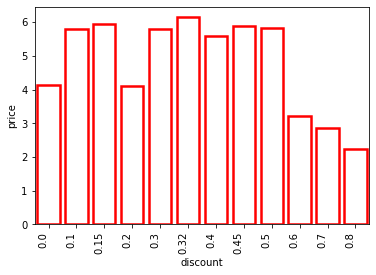

In [69]:
# can make a column out of this. note the price is already log transformed thus small values in price in y axis.
temp = pd.DataFrame(data1.groupby(['discount'], axis=0, as_index=False)['price'].mean())
plt.figure(figsize=(6,4))
graph = sns.barplot(y="price", x="discount",data=temp,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".4", edgecolor="red")

graph = graph.set_xticklabels(graph.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')

In [70]:
def Mapper_price(num):
    t = 0
    if num > 0.4:
        return t
    else:
        t = 1
        return t
    
data1['Mapped_discount_price'] = data1['price'].apply(Mapper_price)
data1.head(2)

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,...,West,First Class,Same Day,Second Class,Standard Class,address code_new,Mapped_discount,subclass_discount_mapped,departure_city_duration_binned,Mapped_discount_price
0,1,Houston,0.2,2.800204,2,Central,kariox,Consumer,phone,Standard Class,...,0,0,0,0,1,67,1,0.072368,7,0
1,2,Westland,0.0,3.391147,5,Central,kariox,Consumer,headset,Standard Class,...,0,0,0,0,1,13,1,0.369561,3,0


In [71]:
data1.isnull().sum()

id                                   0
departure city                       0
discount                             0
price                                0
no of items                          0
location                             0
class                                0
segment                              0
sub-class                            0
delivery type                        0
RID                                  0
profit                               0
delivery date                        0
address code                         0
departure state                      0
placement date                       0
duration                             0
discount_binned                      0
no of items_binned                   0
Consumer                             0
Corporate                            0
Home Office                          0
fynota                               0
kariox                               0
qexty                                0
Central                  

In [72]:
data1['year'] = data1['placement date'].dt.year
data1['month'] = data1['placement date'].dt.month
data1['day'] = data1['placement date'].dt.day
data1['week'] = data1['placement date'].dt.week
data1['which_day'] = data1['placement date'].dt.dayofweek
data1['quarter'] = data1['placement date'].dt.quarter

In [73]:
feature_set = data1.copy()
backup = data1.copy()

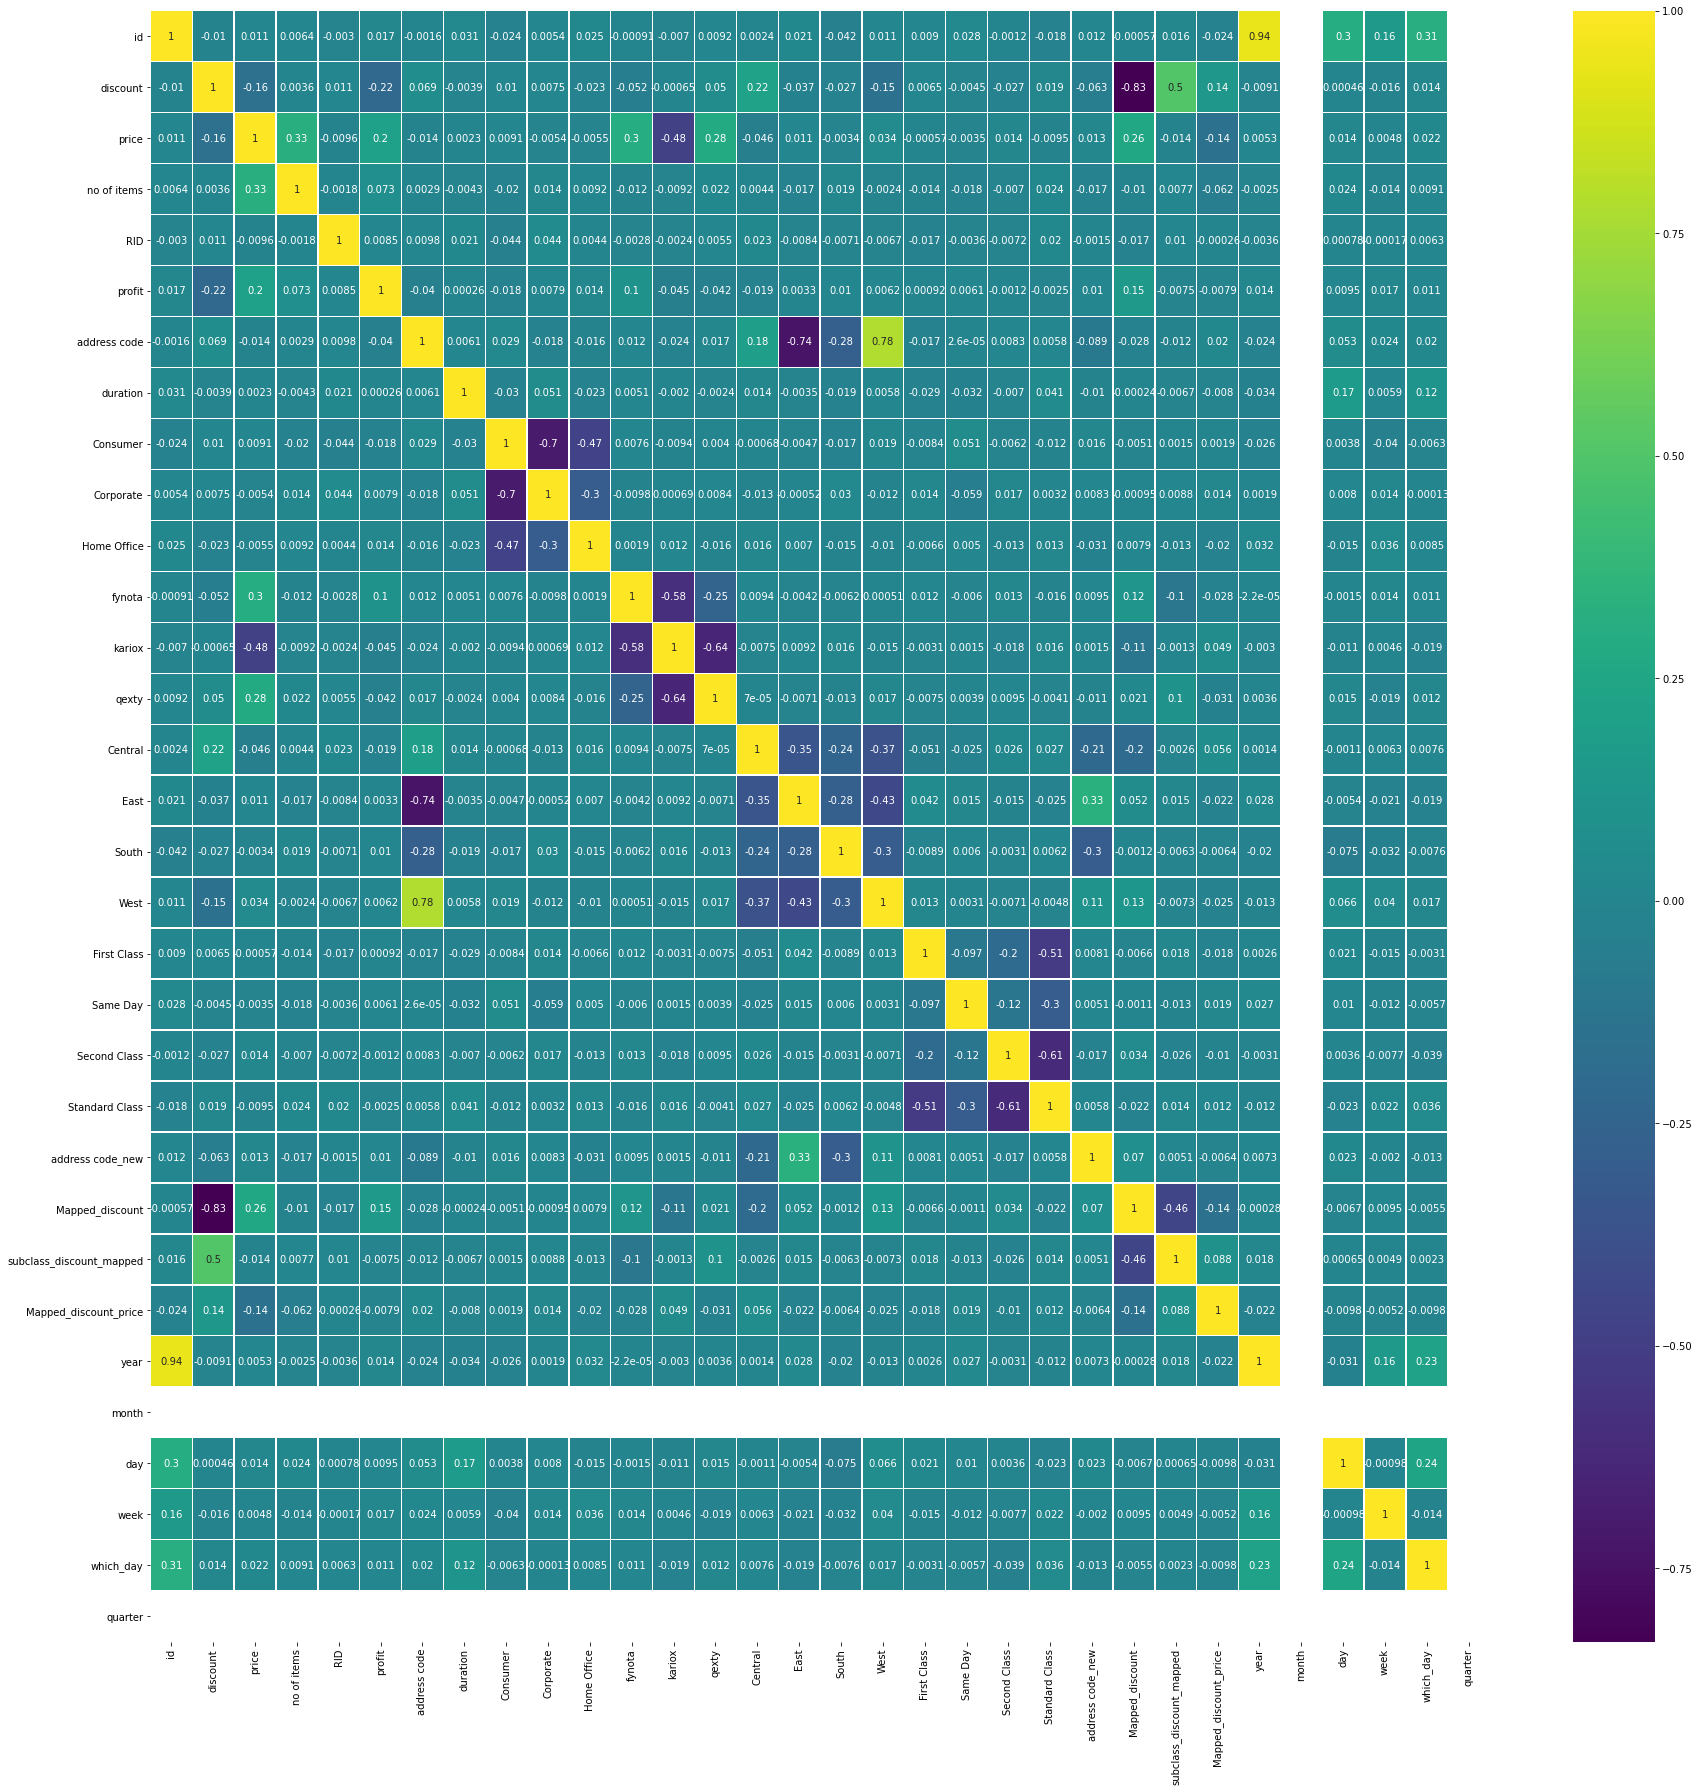

In [74]:
plt.figure(figsize=(30,30))
sns.heatmap(feature_set.corr(),annot=True,cmap='viridis',linewidths=.4)

In [76]:
feature_set1 = feature_set.drop(['id', 'departure city', 'location',
                                'class', 'segment', 'sub-class', 'delivery type', 'RID',
                                'delivery date', 'address code', 'departure state', 'placement date',
                                 'Mapped_discount', 'Corporate', 'month'], axis = 1)

In [77]:
feature_set1.columns

Index(['discount', 'price', 'no of items', 'profit', 'duration',
       'discount_binned', 'no of items_binned', 'Consumer', 'Home Office',
       'fynota', 'kariox', 'qexty', 'Central', 'East', 'South', 'West',
       'First Class', 'Same Day', 'Second Class', 'Standard Class',
       'address code_new', 'subclass_discount_mapped',
       'departure_city_duration_binned', 'Mapped_discount_price', 'year',
       'day', 'week', 'which_day', 'quarter'],
      dtype='object')

In [78]:
feature_set1.isnull().sum()

discount                             0
price                                0
no of items                          0
profit                               0
duration                             0
discount_binned                      0
no of items_binned                   0
Consumer                             0
Home Office                          0
fynota                               0
kariox                               0
qexty                                0
Central                              0
East                                 0
South                                0
West                                 0
First Class                          0
Same Day                             0
Second Class                         0
Standard Class                       0
address code_new                     0
subclass_discount_mapped             0
departure_city_duration_binned    6231
Mapped_discount_price                0
year                                 0
day                      

# Used PCA

In [107]:
from sklearn.decomposition import PCA

pca = PCA(n_components=24)
y = feature_set1['profit']

fe = feature_set1.drop(['profit', 'departure_city_duration_binned', 'qexty', 'Standard Class'], axis = 1)
# fit and transform data
X_pca = pca.fit_transform(fe)

In [108]:
Xtrain ,Xtest, ytrain, ytest = train_test_split(fe, y, test_size = 0.1, random_state=1)

In [109]:
random_model = RandomForestRegressor(n_estimators=500)

In [134]:
#Fit
random_model.fit(Xtrain, ytrain)

y_pred3 = random_model.predict(Xtest)

#Checking the accuracy
random_model_accuracy = round(random_model.score(Xtrain, ytrain)*100,2)
print(round(random_model_accuracy, 2), '%')

93.31 %


In [111]:
#Checking the accuracy
random_model_accuracy1 = round(random_model.score(Xtest, ytest)*100,2)
print(round(random_model_accuracy1, 2), '%')

53.87 %


# Didnt use PCA

In [116]:
fe1 = feature_set1.drop(['profit', 'departure_city_duration_binned', 'qexty', 'Standard Class'], axis = 1)

X_train ,X_test, y_train, y_test = train_test_split(fe1, y, test_size = 0.1, random_state=1)

In [117]:
#Fit
random_model.fit(X_train, y_train)

y_pred3 = random_model.predict(X_test)

#Checking the accuracy
random_model_accuracy = round(random_model.score(X_train, y_train)*100,2)
print(round(random_model_accuracy, 2), '%')

92.48 %


In [118]:
#Checking the accuracy
random_model_accuracy1 = round(random_model.score(X_test, y_test)*100,2)
print(round(random_model_accuracy1, 2), '%')

52.69 %


In [119]:
test_score = r2_score(y_test, y_pred3)

In [120]:
test_score

0.5269404230754229

In [122]:
"""
n_estimators = number of trees in the foreset
max_features = max number of features considered for splitting a node
max_depth = max number of levels in each decision tree
min_samples_split = min number of data points placed in a node before the node is split
min_samples_leaf = min number of data points allowed in a leaf node
bootstrap = method for sampling data points (with or without replacement)
"""

from sklearn.model_selection import RandomizedSearchCV

In [123]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 700, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 55, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 255, 311, 366, 422, 477, 533, 588, 644, 700], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 14, 19, 23, 28, 32, 37, 41, 46, 50, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [124]:
# Xtrain ,Xtest, ytrain, ytest = train_test_split(fe, y, test_size = 0.1, random_state=1) - use this

In [125]:
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

# n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(Xtrain, ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 20.6min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 14, 19, 23, 28, 32,
                                                      37, 41, 46, 50, 55,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 255, 311, 366,
                                                         422, 477, 533, 588,
                                                         644, 700]},
                   random_state=42, verbose=2)

In [126]:
rf_random.best_params_

{'n_estimators': 311,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 55,
 'bootstrap': False}

In [135]:
model1 = RandomForestRegressor(n_estimators= 311,
 min_samples_split= 2,
 min_samples_leaf= 2,
 max_features='sqrt',
 max_depth= 55,
 bootstrap= False)

In [136]:
#Fit
model1.fit(Xtrain, ytrain)

y_pred3 = model1.predict(Xtest)

#Checking the accuracy
random_model_accuracy = round(model1.score(Xtrain, ytrain)*100,2)
print(round(random_model_accuracy, 2), '%')

91.76 %


In [137]:
#Checking the accuracy
random_model_accuracy1 = round(model1.score(Xtest, ytest)*100,2)
print(round(random_model_accuracy1, 2), '%')

40.99 %


In [138]:
test_score = r2_score(ytest, y_pred3)

In [139]:
test_score

0.40992390947857815